### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2024 Semester 2

## Assignment 3

## This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS.

In addition to this file, you should submit a written report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

## Estimating depth from Stereo

Standard imports

In [1]:
import numpy as np
from numpy import inf
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import math


2024-10-06 09:18:19.366137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


A function to load an image file from the Middlebury dataset and downsample it by a factor of scale

In [2]:
def loadim(filename, scale):
    im = cv2.imread(filename)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = tf.cast(im,tf.float32) # cast the tensor to a new type
    shape = im.shape   # im is in 3-dim
    shape = [1,*shape] # make im in 4-dim
    im = tf.reshape(im,shape)
    im = tf.nn.avg_pool2d(input=im, ksize=(scale,scale), strides = (scale,scale), padding='VALID')
    return im

A function to load a disparity file from the Middlebury dataset and downsample it by a factor of scale

This function also modifies the offsets in the tensor by a factor of scale so that it is consistent with images at that scale

In [3]:
def loaddisparity(filename, scale):
    disp = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    with Path(filename).open('rb') as pfm_file:
        line1, line2, line3 = (pfm_file.readline().decode('latin-1').strip() for _ in range(3))
    fscale = abs(float(line3))

    # clean up the image and rescale
    disp[disp==inf]=0
    shape = disp.shape
    shape = [1,*shape,1]
    disp = tf.reshape(disp,shape)
    disp = tf.nn.max_pool2d(input = disp, ksize = (scale, scale), strides=(scale, scale), padding ='VALID')
    disp = disp * fscale / scale
    return disp


select a directory from the Middlebury dataset containing an image pair and corresponding disparities

The images are big (2016 high and 2940 wide) - so choose a scale to downsample them to more manageable size

Specify the size of window to use for matching

In [4]:
# names for the image folders
filepaths = ['Adirondack', 'Backpack', 'Cable', 'Classroom1', 'Mask', 'Motorcycle', 'Piano', 'Pipes', 'Playroom' ,'Vintage']
filepath = 'Middlebury/' + filepaths[1] + '-perfect' # select a stereo pair to work on
scale = 8 # scale factor to shrink the images by 8 4 2
halfwin = 2 # number of pixels each side of the centre pixel to include in the matching

Load two images and two disparities

In [5]:
im0 = loadim(filepath + '/im0.png', scale)
im1 = loadim(filepath + '/im1.png', scale)
disp0 = loaddisparity(filepath+'/disp0.pfm',scale)
disp1 = loaddisparity(filepath+'/disp1.pfm',scale)

2024-10-06 09:19:16.647124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Display them

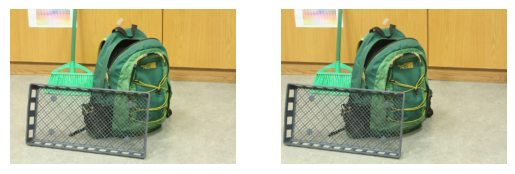

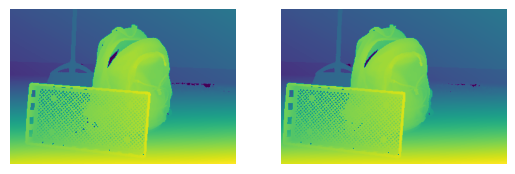

In [6]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(tf.cast(im0[0],tf.uint8).numpy())
axarr[0].set_axis_off()
axarr[1].imshow(tf.cast(im1[0],tf.uint8).numpy())
axarr[1].set_axis_off()

f, axarr = plt.subplots(1,2)
axarr[0].imshow(disp0[0])
axarr[0].set_axis_off()
axarr[1].imshow(disp1[0])
axarr[1].set_axis_off()

In [7]:
print(im0.shape, disp0.shape)

(1, 252, 367, 3) (1, 252, 367, 1)


## Image warping

Use the ground truth disparity map to warp im0 to move the pixels to where they should be for im1

NB: this is very slow because we're workign one pixel at a time. At scale=8 this cell takes 15s on my M1 macbook air.

If you get worried that this is not working, try printing out i each time a row changes to monitor it

In [8]:
if scale>7: 
    remapped = np.zeros(im0.shape) # a black image that has the same shape as im0
    b,rows,cols,_ = im0.shape
    
    for i in range(rows):
        for j in range(cols):
            offset = disp0[0,i,j,0] # get the disparity value of im0
            joff = int(j-offset)    # shifted coordinates in remapped
            
            # shift the image to left by its corresponding depth in the disparity map
            # when this pixel in the disp0 has non-zero disparity and
            # the shifted coordinates don't go beyond the frame
            if(offset > 0 and joff >=0 and joff < cols):
                remapped[0,i,joff,:] = im0[0,i,j,:]

Display the im0->im1 warped image alongside im1 for comparison

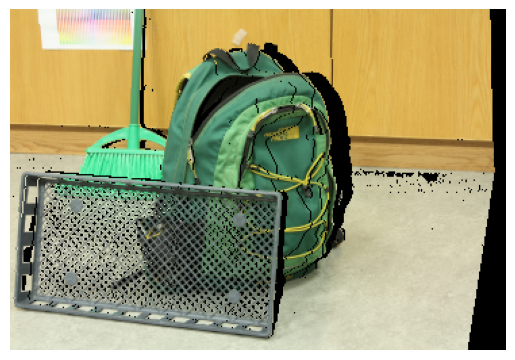

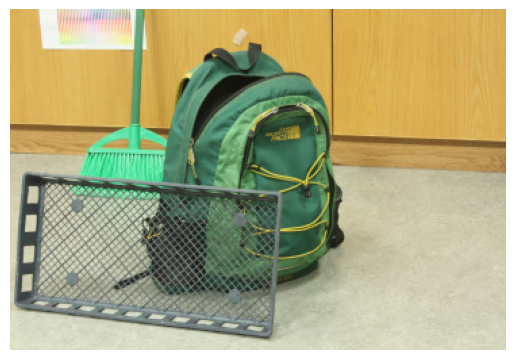

In [9]:
if scale > 7:
    plt.figure(0)
    fig=plt.imshow(tf.cast(remapped[0],tf.uint8).numpy())
    fig.axes.set_axis_off()
    plt.figure(1)
    fig=plt.imshow(tf.cast(im1[0],tf.uint8).numpy())
    fig.axes.set_axis_off()

## Compute Disparity

Conduct a sweep over offets computing the squared error at each pixel between im1 and a shifted im0

In [10]:
#cheat a bit so that we're only considering disparities up to the maximum disparity in the ground truth
# maxoffset = 28
maxoffset = math.ceil(float(tf.math.reduce_max(disp0)))

b,rows,cols,_ = im0.shape
diffsumsq = []

# scan over the offset range we're interested in
# the range contains 28 disparity values
# shift im0 to left
# shift im1 to right
for offset in range(maxoffset):
    # crop im1 and shift im0 to the right, then calculate the difference between them
    diff = im1[0,:,0:cols-maxoffset,:] - im0[0,:,offset:cols-maxoffset+offset,:]
    
    # squared errors 
    diffsq = diff*diff
    
    # sum over r,g,b errors and stack the error images into a list
    diffsumsq.append(tf.math.reduce_sum(diffsq,axis=-1,keepdims=True))
    
# turn the list of error images into a tensor - batch dimension scans over the offsets
diffsumsq = tf.stack(diffsumsq)

Make a kernel to add up the squared errors within a window

In [12]:
windowsize = 2 * halfwin + 1 

kshape = [windowsize,windowsize,1,1]
# # uniform kernel
# kernel = np.ones(kshape)

# Gaussian kernel
# 1d Gaussian kernel (size, sigma)
kernel = cv2.getGaussianKernel(windowsize, halfwin/2) 

# product two 1d kernels to get an 2d filter
kernel = np.outer(kernel, kernel) 
kernel = np.expand_dims(kernel, axis=(2, 3))
kernel.shape

(5, 5, 1, 1)

Convolve the kernel with the stack of squared error images to get the squared error within each window at each offset

In [13]:
windowdiffsumsq = tf.nn.conv2d(diffsumsq,kernel,strides=1,padding='VALID')

sample the offsets and display the sum squared error within each window at each offset

Features should disappear at the correct disparity

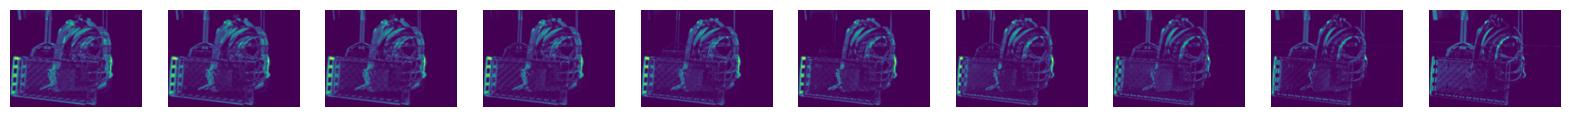

In [14]:
f, axarr = plt.subplots(1,10,figsize=(20,16))
for i in range(10):
    axarr[i].imshow(windowdiffsumsq[i*2])
    axarr[i].set_axis_off()

Find the best disparirty for each pixel by finding the position of the minimum error using argmin

In [15]:
# return the index of the min SSD for each pixel
# the index is the disparity value ranging from 0 to 27
bestoffset = tf.math.argmin(windowdiffsumsq, axis=0)
bestoffset = tf.cast(bestoffset,tf.float32)

In [16]:
# the map that has minimum sum of error over all images
bestoffset = tf.math.argmin(windowdiffsumsq, axis=0)
bestoffset = tf.cast(bestoffset,tf.float32)

Choose the part of the ground truth disparity image that corresponds to the one we have computed taking into account pixels lost due to windowing and from the disparity sweep

In [17]:
outr, outc, _ = bestoffset.shape
gt = disp1[0, halfwin:halfwin+outr, halfwin:halfwin+outc,:]

Display our computed disparity and the ground truth disparity

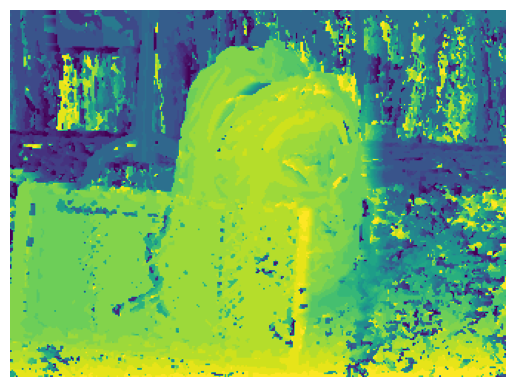

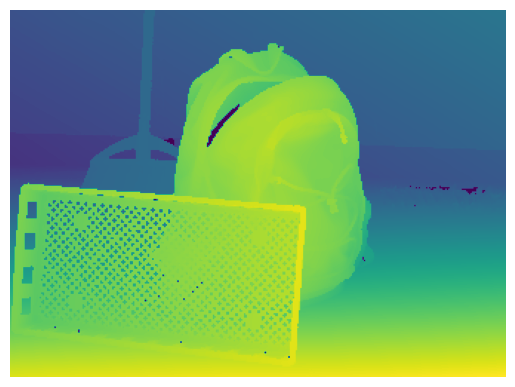

In [18]:
plt.figure(0)
fig = plt.imshow(bestoffset)
fig.axes.set_axis_off()
plt.figure(1)
fig = plt.imshow(gt)
fig.axes.set_axis_off()

Calculate how well we did.  Count the number of pixels for which we have a ground truth disparity that are within a disparity error of 2.5 pixels of the ground truth and report as an accuracy percentage

In [19]:
disperror = tf.math.abs(bestoffset - gt)

could = gt!=0 # only compare pixel that has disparity (depth) in gt
good = tf.logical_and(could, disperror < 2.5) # has disparity and error < 2.5

numgood = (int(tf.math.count_nonzero(good)))
numcould = (int(tf.math.count_nonzero(could)))

print (numgood, ' out of ', numcould, ' pixels = ', 100*numgood/numcould, '%')

59340  out of  82892  pixels =  71.58712541620422 %
